# Bank client outflow prediction.

The [database from Kaggle.com](https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers) contains following features :
* RowNumber — row number
* CustomerId — customer identification number
* Surname — surename of a client
* CreditScore — credit score. (the higher the credit score the higher the frequency of getting a credit and returning  it)
* Geography — the origin country of a customer
* Gender — client's gender
* Age — client's age
* Tenure — how many years the client uses the banking service
* Balance — client's balance
* NumOfProducts — the number of services used by a client
* HasCrCard — whether the client has a credit card or not (1 — yes, 0 — no 
* IsActiveMember — if the client has an active member status (1 — yes, 0 — no)
* EstimatedSalary — estimated client's salary
* Exited — loyalty status, **the target value** (1 — exited client, 0 — loyal client)

In [1]:
# import main librariees
import pandas as pd
import numpy as np 
import os, sys

# Graphical libraries
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
plt.style.use('fast')

# ML libraries
from sklearn import linear_model, metrics, preprocessing, tree, ensemble
from sklearn.model_selection import train_test_split 

# set random seed
random_seed = 42

#set path
sys.path.insert(1, '../')

In [2]:
churn_data = pd.read_csv('../data/churn.zip', sep=',') 

# copy the bd to preserve the original dataset
churn_df = churn_data.copy()

# drop the useless feature RowNumber  
churn_df.drop(['RowNumber'], axis=1, inplace=True) 

#Создадим графу 'client status' для наглядного отображения статуса пользования банком
churn_df['client status'] = churn_df['Exited'].astype('category').cat.rename_categories({0:'Loyal', 1:'Exited'})

churn_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,client status
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Exited
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Loyal
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Exited
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Loyal
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Loyal


## Ratio of exited clients to loyal clients

In [3]:
# data
df=churn_df['client status'].value_counts().sort_values(ascending=False)

fig = px.pie(
    data_frame = df,
    values = 'client status',
    names = df.index,
    width=500, height=400
)

fig.update_layout(
    title=dict(text="Fig.1 - Client distribution by status", x=0.5, y=0.1, xanchor='center'),
    legend_title_text='Status:'
)
#fig.update_traces(textposition='inside', textinfo='percent+label')
#fig.show();

fig.write_image('../figures/fig_1.png', engine="kaleido")

<center> <img src = "../figures/fig_1.png"></center>

The fig.1 represents the client distribution by status. There are some 10000 clients in the database. The majority 79.6% (7963 ppl) uses the banking service though some 20.4% (2037 ppl) decided to exit the bank.

## Customer balances distribution

Let us study customer balances exceeding randomly chosen value of 2500$ (clients who actually use their accounts). 

In [4]:
fig = px.box(
    data_frame = churn_df[churn_df['Balance'] > 2500],
    x = 'Balance',
    height=250, width=700, 
)

fig.update_layout(
    title=dict(text='Fig.2 - Customer balances distribution over 2500$', x=.5, y=0.05, xanchor='center'),
    xaxis_title_text = 'balance, $', yaxis_title_text = 'clients'
)

#fig.show()
fig.write_image('../figures/fig_2.png', engine="kaleido")

<center> <img src = "../figures/fig_2.png">

На рис.2 изображено распределение балансов клиентских счетов, превосходящие 2500 долларов.
* В базе содержится 6383 клиента с таким остатоком на счету. Примерно половина из них (3250 клиента) имеют от 100 тыс. до 140 тыс. долларов на счету.
* Распределение баланса клиентского счета симметрично относительно среднего значения около 119827 долларов со стандартным отклонением около 30095 долларов. Медианный остаток составляет около 119840 долларов. 
* Половина клиентов имеет на счету средства, величина которых находится в относительно узком диапазоне. Межквартильный размах (IQR) составляет 39330 доллара. Границы распределения (диапазона) определим по формуле: нижняя граница Q25 - 1,5*IQR = 100182 - 1.5*39330 = 41187 долларов; верхняя граница Q75 + 1.5*IQR = 139512 + 1.5*39330 = 198507 долларов. 
* Минимальный остаток на счету составляет 3769 долларов, а максимальный 250898 долларов.
* Распределение данных близко к нормальному.

# Задание 9.3. 
---------- 
Посмотрите на распределение баланса клиента в разрезе признака оттока. Как различаются суммы на накопительном счёте ушедших и лояльных клиентов? Подумайте и напишите, с чем это может быть связано, что может не устраивать ушедших клиентов в банке.

In [5]:
#блочная диаграмма с помощью библиотеки Plotly

fig = px.box(
    data_frame = churn_df,
    x = 'Balance',
    y = 'client status',
    color = 'client status',
    height=300, width=800, 
)
fig.update_layout(
    title=dict(text='Fig.3 - распределение баланса счетов <br> в зависимости от статуса использования банка', x=.5, xanchor='center'),
    xaxis_title_text = 'Баланс клиента, доллар', yaxis_title_text = 'Статус <br>клиента', legend_title_text='Статус клиента:', 
)
#fig.show()
fig.write_image('../figures/fig_3.png', engine="kaleido")

<center> <img src = "../figures/fig_3.png">

На рис.3 изображена блочная диаграмма распределения остатков на счетах клиентов в разрезе признака оттока. Анализируя диаграммы, можно сказать, что у половины из 2037 покинувших банк клиентов на счету было от 37896 до 131435 долларов с медианным остатком около 109349 долларов. У половины оставшихся клиентов баланс составляет от 0 до 126419 долларов с медианным остатком около 92072 доллара. Такое различие между распределениями статка счёта позволяет сделать вывод о целях использования счетов клиентами: 
* большая часть ушедших клиентов хранила значительные суммы на счетах;
* текущие клиенты банка чаще используют счёт для текущих расходов и имеют меньший остаток, чем ушедшие клиенты.


## Age to client status

In [49]:
fig = px.box(
    data_frame = churn_df,
    x = 'Age',
    y = 'client status',
    color = 'client status',
    width=800, height=300,
)
fig.update_layout(
    title=dict(text='Fig. 4 - age to status distribution', x=.5, y=0.05, xanchor='center'),
    xaxis_title_text = 'Age of client, years', yaxis_title_text = 'Status',  
    legend_title_text='Status:'
)
#fig.show()
fig.write_image('../figures/fig_4.png', engine="kaleido")

<center> <img src = "../figures/fig_4.png">

The age to client status distribution is shown on the fig.4. One can addmitt: 
* Median age of loyal clients is 36 years. The group contains many outliers, queing outside of the right boundary;
* Median age of the exited clients is 45 years. A half of them can be named as a 'risky age group' is within the range between 38 and 51 years. The bank managers should point attention to this age group.

## Credit rating vs estimated salary

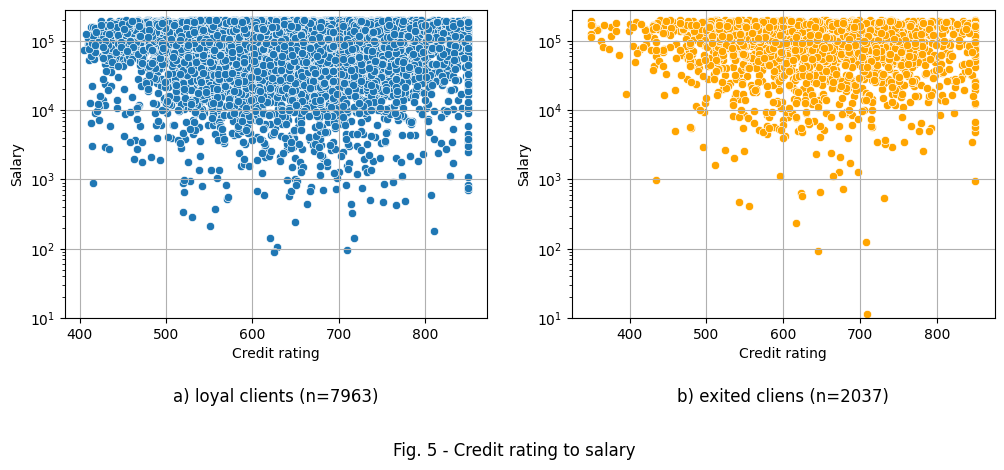

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# diagram1
sns.scatterplot(
    data=churn_df[churn_df['client status'] == 'Loyal'],
    x='CreditScore',
    y='EstimatedSalary', #marker="+",
    ax=ax[0]    
    ); 
# logarythmic scale
ax[0].set(yscale="log") #xscale="log"
ax[0].set_ylim(10, 2.8*10e4)
ax[0].set_xlabel('Credit rating')
ax[0].set_ylabel('Salary')
ax[0].grid();

# diagram2 
sns.scatterplot(
    data=churn_df[churn_df['client status'] == 'Exited'], #
    x='CreditScore',
    y='EstimatedSalary', 
    ax=ax[1],
    color='orange',
    ); 

# логарифмическая шкала по оси У
ax[1].set(yscale="log",) #xscale="log"
ax[1].set_ylim(10, 2.8*10e4)

ax[1].set_xlabel('Credit rating')
ax[1].set_ylabel('Salary')

ax[1].grid()

fig.suptitle('Fig. 5 - Credit rating to salary', fontsize=12, y=-0.20)
ax[0].set_title('a) loyal clients (n=7963)',y=-0.30,loc='center') #, , 
ax[1].set_title('b) exited cliens (n=2037)',y=-0.30,loc='center'); #, loc='center', y=-0.1

plt.savefig(f'../figures/fig_5.png')

Analyzing the credit rating to salary distribution on fig.5 it can be inferred:
* the rating does not correlate with salary in general. It implies that most of the client use the credit program.
* most of clients despite status are supposed to have salary between 100090 $\pm$ 57510 usd.

## Exited clients genders

In [52]:
df=churn_df[churn_df['client status'] == 'Exited']['Gender'].value_counts()

fig = px.pie(
    data_frame = df,
    values = 'Gender',
    names = df.index,
    width=400, height=300,
)

fig.update_layout(
    title=dict(text='Fig.6 - Genders of exited clients', x=.5, y=0.1, xanchor='center'),
    legend_title_text='Gender:'
)
#fig.show()
fig.write_image('../figures/fig_6.png', engine="kaleido");

# encoding
churn_df['Gender'] = churn_df['Gender'].apply(lambda x: 1 if x == 'Male' else '0')

<center> <img src = "../figures/fig_6.png">

Analyzing the fig.6 it can be addmitted, that women leave the bank more often than men.

## Number of services vs status

In [9]:
df = churn_df.groupby(['NumOfProducts', 'Exited'], as_index=False).count()

fig = px.bar(
    data_frame=df,
    x='NumOfProducts',
    y=df.index,
    color='Exited',
    height=400,
    width=600,
    labels={'Exited':'Статус','RowNumber':'Количество клиентов','NumOfProducts':'Количество продуктов'},
    title='Fig.7 - Services used by exit clients',
    category_orders={'Exited': [1, 0]},
)

#fig.show()
fig.write_image('../figures/fig_7.png', engine="kaleido")

<center> <img src = "../figures/fig_7.png"> </center>

На рис.7 изображена диаграмма использования услуг банка ушедшими клиентами в зависимости от продолжительности использования услуг банка и наличия кредитной карты. Анализируя диаграмму, можно сделать следующие выводы:
* ушедшие клиенты пользовались банком около 5 лет;
* вариации у признаков "использование кредитной картой" и "количество приобретенных услуг" встречаются одинаково часто, что горвоит о том, что данные признаки не имели существенного влияния на желание покинуть банк.

## Active client status vs status

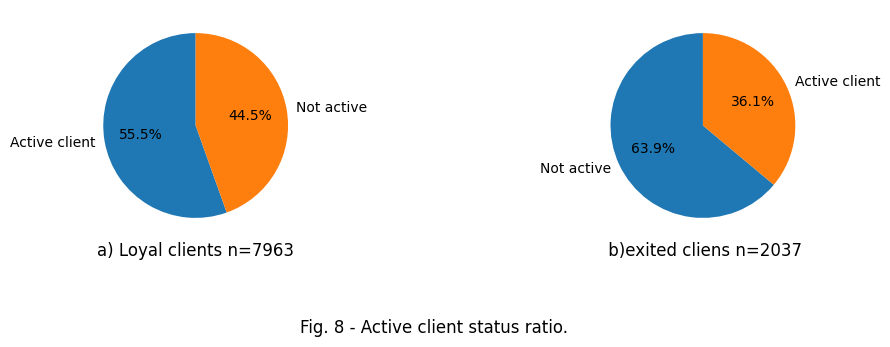

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3)) 
labels = 'Active client', 'Not active'
labels1 =  'Not active', 'Active client'

ax1.pie(
    churn_df[churn_df['client status'] == 'Loyal']['IsActiveMember'].value_counts().sort_values(ascending=False),
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
)


ax2.pie(
    churn_df[churn_df['client status'] == 'Exited']['IsActiveMember'].value_counts().sort_values(ascending=False),
    labels=labels1,
    autopct='%1.1f%%',
    startangle=90,
)

fig.suptitle('Fig. 8 - Active client status ratio.', fontsize=12, y=-0.15)
ax1.set_title('a) Loyal clients n=7963', loc='center', y=-0.1)
ax2.set_title(' b)exited cliens n=2037', loc='center', y=-0.1);

На рис.8 изображены диаграммы, показывающие клиентов с ушедшими клиетами по статусу активного клиента. Анализируя диаграммы, можно сделать следующий вывод:
* среди клиентов банка больше тех, которые имеют статус.
* среди покинувших банк клиентов больше "пассивных" - тех, которые не имели статуса. В связи с этим, можно порекоммендовать банку активнее выявлять потребности "пассивных" клиентoв и предлагать им соответствующие услуги.

# Задание 9
----------
В какой стране доля ушедших клиентов больше? Постройте тепловую картограмму, которая покажет это соотношение на карте мира. Предположите, с чем это может быть связано.

In [ ]:
#данные
df = churn_data.groupby(['Geography'], as_index=False).mean(numeric_only=True)
#Количество 
#churn_df[churn_df['Exited']==1].groupby(['Exited','Geography'] , as_index=False).count() 

# построим картограмму с помощью библиотеки Plotly
fig = px.choropleth(
    df,
    locations="Geography",
    locationmode = "country names",
    color='Exited', #CustomerId
    title='Рис. 9 - Распределение ушедших клиентов по странам', 
    width=800,
    height=400,
    color_continuous_scale="Burg",
    labels={'Exited':'Покинувшие банк клиенты'}
)
fig.update_layout(title_font_size=16)
#fig.show()
fig.write_image('../figures/fig_9.png', engine="kaleido")

<center> <img src = "../figures/fig_9.png"> </center>

На рис.9 изображена диаграмма распределения ушедших клиентов по странам. Анализируя диаграмму отметим, что больше всего клиентов, 32.4%, покинуло немецкий филиал банка. Французский испанский филиалы банка покинуло примерно 16% кдиентов.
Принимая во внимание предыдущие диаграммы отметим, что кдиентам среднего возраста с высокой зарплатой из Германии и могло не понравитья особенности начисления кредитного рейтинга. Возможно, что из-за этого они начали активно пользоваться кредитной программой и не получили статус "активного клиента".

# Задание 10
----------
Переведите числовой признак CreditScore в категориальный. Для этого воспользуйтесь функцией get_credit_score_cat(), которая приведена ниже. Примените её к столбцу CreditScore и создайте новый признак CreditScoreCat — категории кредитного рейтинга.

Постройте сводную таблицу, строками которой являются категории кредитного рейтинга (CreditScoreCat), а столбцами — количество лет, в течение которых клиент пользуется услугами банка (Tenure). В ячейках сводной таблицы должно находиться среднее по признаку оттока (Exited) — доля ушедших пользователей.

На основе полученной сводной таблицы постройте тепловую карту с аннотацией. Найдите на тепловой карте категории клиентов, которые уходят чаще всего.

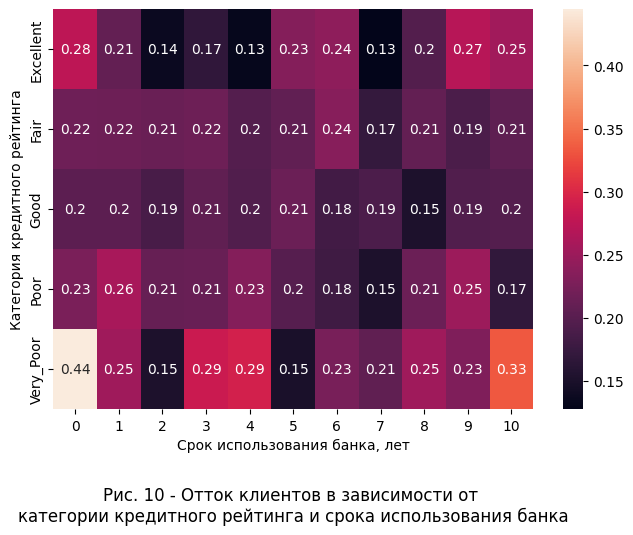

In [ ]:
#функция распределения кредитного рейтинга на 5 групп по его значению
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score >= 851:
        return "Top"
    elif credit_score < 300:
        return "Deep"
    
# Отобразим результат в графе 'CreditScoreCat'
churn_df['CreditScoreCat'] = churn_df['CreditScore'].apply(get_credit_score_cat) 

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0, 0, 1, 1))

#данные
df = churn_df.pivot_table(values='Exited', index='CreditScoreCat', columns='Tenure', aggfunc='mean')

# строим тепловую диаграму с помощью библиотеки Seaborn. Параметр 'annot=True' показывает значения на диаграмме
sns.heatmap(df, annot=True ); #linewidths=.05

ax.set_title('Рис. 10 - Отток клиентов в зависимости от \nкатегории кредитного рейтинга и срока использования банка', fontsize=12, y=-0.3)
ax.set_xlabel('Срок использования банка, лет')
ax.set_ylabel('Категория кредитного рейтинга');

plt.savefig(f'../figures/fig_10.png')

На рис.10 изображена диаграмма оттока клиентов в зависимости от категории кредитного рейтинга и срока использования банка. Анализируя диаграмму, можно сделать следующие выводы:
* у клиеентов с очень низким кредитным рейтингом('very_poor') наблюдается максимальный отток (в порядке убывания интенсивности) втечение : 1, 4 и 5 года пользования банком. Возможно, уход клиентов обусловлен следующими мотивами: разочарование от низкой величиной кредитного рейтинга у вновь пришедших клиентов, которое ежегодно уменьшается в половину по мере использования кредитной программы. На 4 и 5 году это неприятие вновь увеличивается и разочарованные клиенты уходят. С 6-го года клиенты привыкают к условиям программы, но недовольство ею остаётся вплоть до 11-го года пользования банком.
* у клиентов с рейтингами 'poor', 'good', 'fair' не наблюдается значительных колебаний оттока
* у клиентов с рейтингом группы 'excellent' наблюдается схожая картина оттока по сравнению с группой 'very_poor', но интенсивность её меньше. Максимумы оттока наблюдаются на 1 и 10 и 11 годах. Также всплеск отток наблюдается в середине периода использования банка на 6 и 7 году - т.е. со смещением в 1 год позже  (по сравнению с группой 'very_poor'.

## Correlation between features

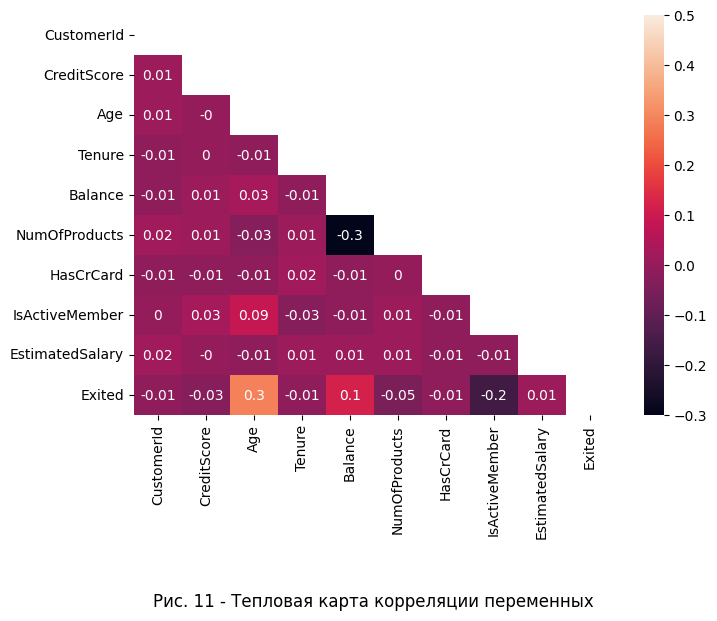

In [ ]:
# let us delete repetitive features
churn_df.drop(['client status', 'CreditScoreCat'], axis=1, inplace=True)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0, 0, 1, 1))
matrix = np.triu(churn_df.corr(numeric_only=True))

fig = sns.heatmap(churn_df.corr(numeric_only=True).round(2), annot=True, fmt='.1g', vmax=0.5, mask=matrix) #, vmax=0.3
ax.set_title('Fig. 11 - Features correlation heatmap', fontsize=12, y=-0.5);

As it can be seen from the heatmap on the fig. 11 one can admit:
* the correlation values do not exceed some 0.3. Thus, there is no multicollinearity between features
* maximal positive correlation is observed between the client's age and his status (target value). One can say elder clients leave the bank;
* maximal negative correlation is observed between the client's balance  and the Number of products. The higher the balance the lower the number of services used by the client.

Suppose causes of the client outflow are varying by country. So let us create different models for each county. 

In [ ]:
churn_data_cleaned = churn_df[churn_df['Geography'] == 'Germany']
print('Shape:', churn_data_cleaned.shape)
# (2509, 14)
churn_data_cleaned.head()

Shape: (2509, 14)


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Пол
7,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,0
15,15643966,Goforth,616,Germany,Male,45,3,143129.41,2,0,1,64327.26,0,1
16,15737452,Romeo,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1,1
26,15736816,Young,756,Germany,Male,36,2,136815.64,1,1,1,170041.95,0,1
28,15728693,McWilliams,574,Germany,Female,43,3,141349.43,1,1,1,100187.43,0,0


Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [ ]:
churn_data_cleaned = churn_data_cleaned.drop(['CustomerId', 'Surname', 'Geography', 'Gender'], axis=1).rename(columns={'Пол':'Gender'}) #delete and rename features
print('Shape:', churn_data_cleaned.shape)
churn_data_cleaned.head()

Shape: (2509, 10)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender
7,376,29,4,115046.74,4,1,0,119346.88,1,0
15,616,45,3,143129.41,2,0,1,64327.26,0,1
16,653,58,1,132602.88,1,1,0,5097.67,1,1
26,756,36,2,136815.64,1,1,1,170041.95,0,1
28,574,43,3,141349.43,1,1,1,100187.43,0,0


Проверим, что в наших данных нет пропусков:

In [ ]:
churn_data_cleaned.isnull().sum()

CreditScore        0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
Gender             0
dtype: int64

Давайте расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:

* BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;
* TenureByAge — отношение времени пользования банком к возрасту клиента;
* CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.

Также перекодируем единственный текстовый категориальный признак Gender в бинарный столбец (1 — 'Male', 0 — 'Female'):

In [ ]:
churn_data_cleaned['BalanceSalaryRatio'] = churn_data_cleaned['Balance']/churn_data_cleaned['EstimatedSalary']
churn_data_cleaned['TenureByAge'] = churn_data_cleaned['Tenure']/(churn_data_cleaned['Age'])
churn_data_cleaned['CreditScoreGivenAge'] = churn_data_cleaned['CreditScore']/(churn_data_cleaned['Age'])

churn_data_cleaned.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,29,4,115046.74,4,1,0,119346.88,1,0,0.963969,0.137931,12.965517
15,616,45,3,143129.41,2,0,1,64327.26,0,1,2.225020,0.066667,13.688889
16,653,58,1,132602.88,1,1,0,5097.67,1,1,26.012449,0.017241,11.258621
26,756,36,2,136815.64,1,1,1,170041.95,0,1,0.804599,0.055556,21.000000
28,574,43,3,141349.43,1,1,1,100187.43,0,0,1.410850,0.069767,13.348837


Let us assign the target to a separate variable

In [ ]:
X, y = churn_data_cleaned.drop("Exited", axis=1), churn_data_cleaned["Exited"]

Normalization

In [ ]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Let us study classes in target value.

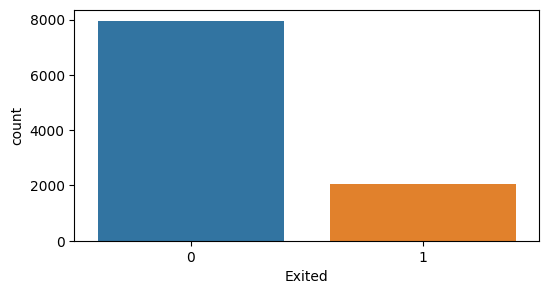

In [ ]:
y.value_counts(normalize=True)

fig = plt.figure(figsize=(6, 3))
sns.countplot(data = churn_data, x='Exited');

As we can see from the histogram, data classes in the target value are unbalances. Therefore, we shall use straitfied 
split method.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0) #random_seed

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))


Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [ ]:
print('Train :\n', y_train.value_counts(normalize=True).round(2))
print('\n')
print('Test :\n', y_test.value_counts(normalize=True).round(2))

Train :
 0    0.68
1    0.32
Name: Exited, dtype: float64


Test :
 0    0.68
1    0.32
Name: Exited, dtype: float64


## Моделирование + оценка модели

В данной задаче нам нужен баланс между $precision$ и $recall$, поэтому мы будем использовать $F1$-меру.

### Логистическая регрессия

In [ ]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #optimization algorythm
    class_weight='balanced', # balancing classes weights
    random_state=0, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0, solver='sag')

In [24]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

#print('F1 score for train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1 score for test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1271
           1       0.63      0.40      0.49       610

    accuracy                           0.73      1881
   macro avg       0.69      0.64      0.65      1881
weighted avg       0.72      0.73      0.71      1881

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       424
           1       0.63      0.38      0.47       204

    accuracy                           0.72       628
   macro avg       0.69      0.63      0.64       628
weighted avg       0.71      0.72      0.70       628

F1 score for train: 0.49
F1 score for test: 0.47


### Полиноминальная регрессия 3 степени

In [25]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

print(f'Кол-во признаков в тренировочной выборке:',X_train_poly.shape[1])

(1881, 454)
(628, 454)
Кол-во признаков в тренировочной выборке: 454


In [26]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_poly, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [27]:
#Выводим отчет по метрикам для тренировочной и тестовой выборок
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

print('F1-score в тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1-score в тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1271
           1       0.78      0.56      0.66       610

    accuracy                           0.81      1881
   macro avg       0.80      0.74      0.76      1881
weighted avg       0.80      0.81      0.80      1881

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       424
           1       0.73      0.56      0.64       204

    accuracy                           0.79       628
   macro avg       0.77      0.73      0.75       628
weighted avg       0.79      0.79      0.78       628

F1-score в тренировочной выборке: 0.66
F1-score в тренировочной выборке: 0.64


### Оптимизация порога вероятности полиноминальной модели

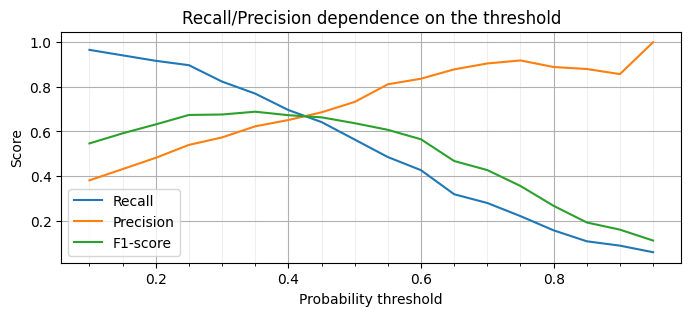

In [28]:
#Считаем вероятности оттока клиентов
y_test_proba_pred = log_reg.predict_proba(X_test_poly)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(8, 3)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

# Major ticks every 20, minor ticks every 5
#major_ticks = np.arange(0, 101, 20)
minor_ticks = np.arange(0, 1, 0.05)
ax.set_xticks(minor_ticks, minor=True)

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Отображаем легенду
ax.legend()
ax.grid()
ax.grid(which='minor', alpha=0.2);

Мы видим на графике:

С увеличением вероятностного порога (treshhold) повышается precision и падает recall. Это означает, что при увеличении порога вероятности мы начинаем классифицировать в качестве "уходящих" тех клиентов клиентов, признаки которых чётче указывают на желание покинуть банк. Таким образом, повышая точность (precision) мы уменьшаем охват (recall).

При этом значение $F1$-меры сначала немного повышается, а затем неуклонно падает. 

В точке threshold=0.43 происходит пересечение всех трёх графиков.  

Однако максимум  $F1$-меры достигается в другой точке — threshold=0.3. При этом значения recall и precision в этой точке различны: recall выше, а вот precision ниже.

In [29]:
thresholds_scores_df = pd.DataFrame({'thresh':thresholds, 'f1-scores':f1_scores}) #.reset_index()
thresholds_scores_df.sort_values(by='f1-scores', ascending=False).head(1)

,thresh,f1-scores
5,0.35,0.688596


In [30]:
best = pd.DataFrame({'thresh':thresholds, 'precision_scores':precision_scores, 'recall_scores':recall_scores}) #.reset_index()
best['best_score'] = best['precision_scores'] - best['recall_scores']
best[['thresh', 'best_score']]

,thresh,best_score
0,0.10,-0.584642
1,0.15,-0.509716
2,0.20,-0.434708
3,0.25,-0.357236
4,0.30,-0.250151
5,0.35,-0.146592
6,0.40,-0.044702
7,0.45,0.043707
8,0.50,0.168759
9,0.55,0.326181


In [31]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35
#Пациентов, для которых вероятность наличия диабета > 0.35 относим к классу 1
#В противном случае - к классу 0
y_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82       424
           1       0.62      0.77      0.69       204

    accuracy                           0.77       628
   macro avg       0.75      0.77      0.76       628
weighted avg       0.79      0.77      0.78       628



### Модель Дерево решений

In [32]:
#Создаём объект класса DecisionTreeClassifier
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=8, #максимальная глубина
    min_samples_leaf = 10, # Минимальное число объектов в листе
    random_state=random_seed #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt.fit(X_train, y_train)

#Делаем предсказание класса для тренировочной выборки
y_pred_train = dt.predict(X_train)
#Выводим отчет о метриках
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))

#Делаем предсказание класса для тестовой выборки
y_pred_test = dt.predict(X_test)
#Выводим отчет о метриках
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

Train: 0.72
Test: 0.65


### Случайный лес

In [33]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    min_samples_leaf = 10, # Минимальное число объектов в листе
    #max_features='sqrt', #число признаков из метода случайных подространств
    random_state=random_seed #генератор случайных чисел
)
#Обучаем модель 
rf.fit(X_train, y_train)

#Делаем предсказание класса для тренировочной выборки
y_pred_train = rf.predict(X_train)
#Выводим отчет о метриках
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))

#Делаем предсказание класса для тестовой выборки
y_pred_test = rf.predict(X_test)
#Выводим отчет о метриках
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

Train: 0.73
Test: 0.64


In [34]:
#Считаем вероятности оттока клиентов модели случайный лес
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
#y_test_proba_pred = pd.Series(y_test_proba_pred)
#y_test_proba_pred.head()

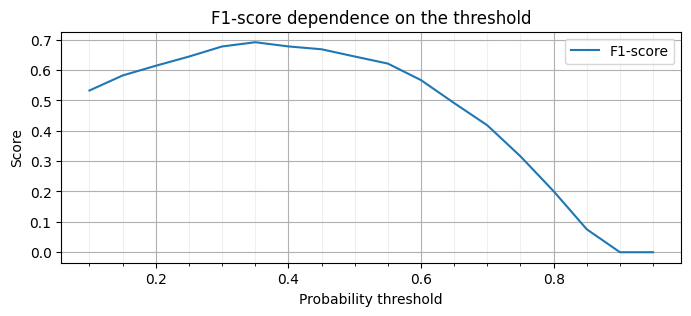

In [35]:
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Клиентов, для которых вероятность оттока > threshold относим к классу 1. В противном случае - к классу 0
    #y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    y_test_pred = np.where(y_test_proba_pred>threshold, 1, 0)
    
    #Считаем метрики и добавляем их в списки
    #recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    #precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(8, 3)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
#ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
#ax.plot(thresholds, precision_scores, label='Precision')

minor_ticks = np.arange(0, 1, 0.05)
ax.set_xticks(minor_ticks, minor=True)
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('F1-score dependence on the threshold') # Recall/Precision dependence on the threshold
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Отображаем легенду
ax.legend()
ax.grid()
ax.grid(which='minor', alpha=0.2);

In [36]:
# Maximal F1-score
max_f1_score = max(f1_scores)

# transform list of f1-scores to array
f1_scores = np.array(f1_scores).round(3)

# The probability value of the best f1-score value
threshold_opt = round(0.05 + (np.argmax(f1_scores) + 1)*0.05, 2)
print(f'Best F1-score: {max_f1_score.round(3)}, Maximal probability: {threshold_opt}')

Best F1-score: 0.692, Maximal probability: 0.35


In [37]:
#Задаем оптимальный порог вероятностей
threshold_opt = threshold_opt
#Клиентов, для которых вероятность оттока > threshold относим к классу 1. В противном случае - к классу 0
#y_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0) # в pandas
y_test_pred = np.where(y_test_proba_pred > threshold, 1, 0)  # в numpy
#Считаем метрики
print(metrics.classification_report(y_test, y_pred_opt))
print('F1-score:', metrics.f1_score(y_test, y_pred_opt).round(3))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82       424
           1       0.62      0.77      0.69       204

    accuracy                           0.77       628
   macro avg       0.75      0.77      0.76       628
weighted avg       0.79      0.77      0.78       628

F1-score: 0.689


Выводы: